# 1. Data Preparation - Experiment Setup

In this notebook the following will be handled:
- Data loading
- Data preprocessing

## Experiment Setup

- **Dataset**: CIFAR-10
- **Low-data setting**: 200 samples per class, 2000 in total
- **Validation**: 5000 samples from remaining training data
- **Test**: Full CIFAR-10 test set, 10.000 samples

## Strategies to compare
- **DADA only**: 2000 images + DADA_aug-generated samples
- **Mixup only**: Mixup on 2000 images
- **CutMix only**: CutMix on 2000 images
- **DADA + Mixup**: Apply Mixup to 2000 images + DADA_aug-generated images
- **DADA + CutMix**: Apply CutMix to 2000 images + DADA_aug-generated images 

## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dada_config import CONFIG, CIFAR10_CLASSES, get_config, print_config, SEED, PATHS_CONFIG

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Created directory: ./saved_data
Created directory: ./models
Created directory: ./results
Created directory: ./logs
Created directory: ./figures


## Random seeds for reproducibility

In [2]:
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data Dictionary

In [3]:
os.makedirs(CONFIG['paths']['data_dir'], exist_ok=True)

print("CIFAR_10_CLASSES:", CIFAR10_CLASSES)

print(f"Current configuration: {CONFIG['name']}")
print(f"Description: {CONFIG['description']}")
print(f"Samples per class: {CONFIG['samples_per_class']}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Data augmentation: {CONFIG['data_augmentation']}")


CIFAR_10_CLASSES: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Current configuration: Hybrid Setup
Description: Hybrid DADA + Mixup/CutMix experiment
Samples per class: 200
Batch size: 32
Data augmentation: True


## Loading the Dataset

The loading of the data is done in an isolated function to:

- Mantain a clean pipeline
- Allows to plug in other datasets in the future easily


In [4]:
def load_cifar10_data():
    """
    Loads the CIFAR-10 dataset and prepares it for training.

    Args:
        None

    Returns:
        tuple: (x_train, y_train), (x_test, y_test)
    """

    print("Loading CIFAR-10 dataset...")
    (x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()
    
    # Labels to 1D array
    y_train_full = y_train_full.ravel()
    y_test = y_test.ravel()

    # Normalize pixel values to [0, 1] for transfer learning
    x_train_full = x_train_full.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    print(f"Dataset loaded: {x_train_full.shape[0]} training samples, {x_test.shape[0]} test samples")

    return (x_train_full, y_train_full), (x_test, y_test)

(x_train_full, y_train_full), (x_test, y_test) = load_cifar10_data()

Loading CIFAR-10 dataset...
Dataset loaded: 50000 training samples, 10000 test samples


## Splitting the Data

In this section the data is split into 3 sets:

- Training set: 200 samples per class
- Validation set: 5000 samples from the remaining unused training data
- Test set: Full CIFAR-10 test set

This setup was chosen to mimic the orignal DADA experiment

In [5]:
def split_data(x_train_full, y_train_full, x_test, y_test, config):
    """
    Splits the CIFAR-10 dataset into training, validation, and test sets.

    Args:
        x_train: Training images.
        y_train: Training labels.
        x_test: Test images.
        y_tes: Test labels.
        config: Configuration parameters.

    Returns:
        dict: Dictionary containing all data splits
    """
    # Lists to store 200 samples per class
    x_train_subset = []
    y_train_subset = []
    remaining_indices = []

    for class_label in range(config['dataset']['num_classes']):
        # Current class indices
        class_indices = np.where(y_train_full == class_label)[0]
        
        # Randomly select 200 samples from the current class
        selected_indices = np.random.choice(
            class_indices,
            size = min(config['dataset']['samples_per_class'], len(class_indices)),
            replace=False
        )

        x_train_subset.append(x_train_full[selected_indices])
        y_train_subset.append(y_train_full[selected_indices])
        
        # Store remaining indices for validation setv
        remaining_indices.extend([idx for idx in class_indices if idx not in selected_indices])
    
    x_train = np.concatenate(x_train_subset, axis=0)
    y_train = np.concatenate(y_train_subset, axis=0)
    remaining_indices = np.array(remaining_indices)

    # Split remaining data into validation set
    np.random.seed(config['random_seed'])
    val_indices = np.random.choice(
        remaining_indices,
        size=min(config['dataset']['val_samples'], len(remaining_indices)),
        replace=False
    )
    x_val = x_train_full[val_indices]
    y_val = y_train_full[val_indices]

    # Shuffle training set
    train_indices = np.arange(len(x_train))
    np.random.seed(config['random_seed'])
    np.random.shuffle(train_indices)
    x_train = x_train[train_indices]
    y_train = y_train[train_indices]

    return {
        'x_train': x_train,
        'y_train': y_train,
        'x_val': x_val,
        'y_val': y_val,
        'x_test': x_test,
        'y_test': y_test
    }

data_splits = split_data(x_train_full, y_train_full, x_test, y_test, CONFIG)

print(f"Training set: {data_splits['x_train'].shape[0]} samples")
print(f"Validation set: {data_splits['x_val'].shape[0]} samples")
print(f"Test set: {data_splits['x_test'].shape[0]} samples")

Training set: 2000 samples
Validation set: 5000 samples
Test set: 10000 samples


## Class Distribution Visualization

This section helps visualize, thanks to a bar chart, how many samples there are per class. 

In [6]:
def plot_class_distribution(y_data, title, classes=CIFAR10_CLASSES):
    """
    Plots the class distribution of the dataset.

    Args:
        y_data: Array of labels.
        title: Title of the plot.
        classes: List of class names.
    Returns:
        None
    """
    
    plt.figure(figsize=(12, 6))
    unique, counts = np.unique(y_data, return_counts=True)
    bars = plt.bar(range(len(unique)), counts, color='skyblue', edgecolor='navy')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Number of Samples', fontsize=12)
    plt.xticks(range(len(unique)), [classes[i] for i in unique], rotation=45, ha='right', fontsize=10)
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(count), 
                 ha='center', va='bottom', fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Statistics
    print(f"Class distribution in {title}:")
    for i, count in zip(unique, counts):
        print(f"{classes[i]}: {count} samples")
    
    print(f"Total samples: {len(y_data)}")
    print(f"Average samples per class: {len(y_data) / len(classes):.2f}")

### Class distribution plots for each split

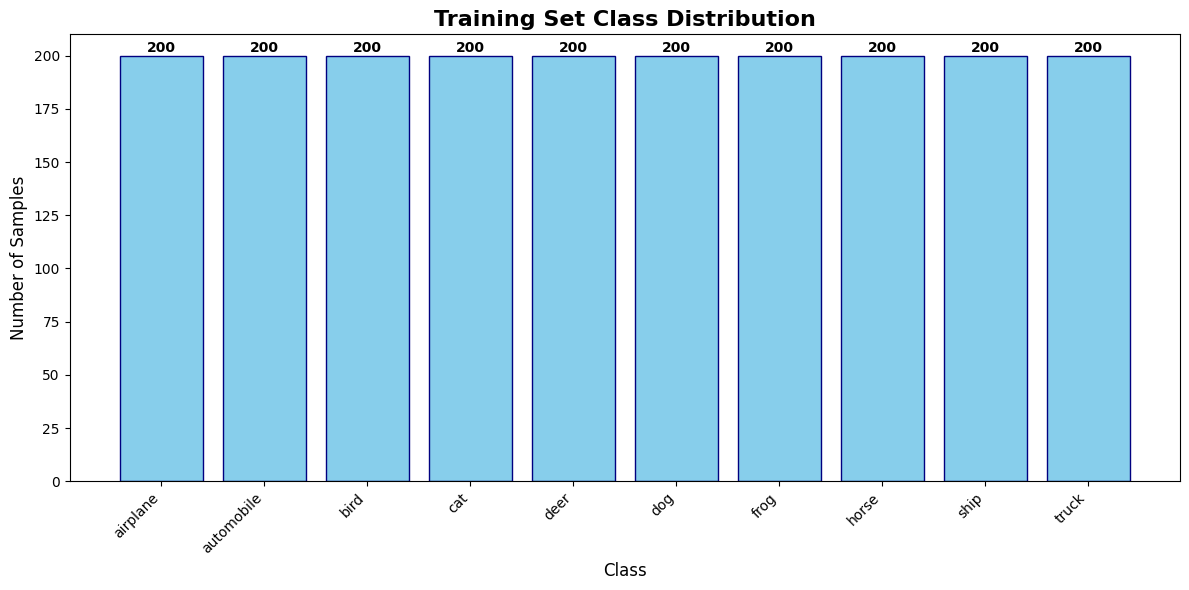

Class distribution in Training Set Class Distribution:
airplane: 200 samples
automobile: 200 samples
bird: 200 samples
cat: 200 samples
deer: 200 samples
dog: 200 samples
frog: 200 samples
horse: 200 samples
ship: 200 samples
truck: 200 samples
Total samples: 2000
Average samples per class: 200.00


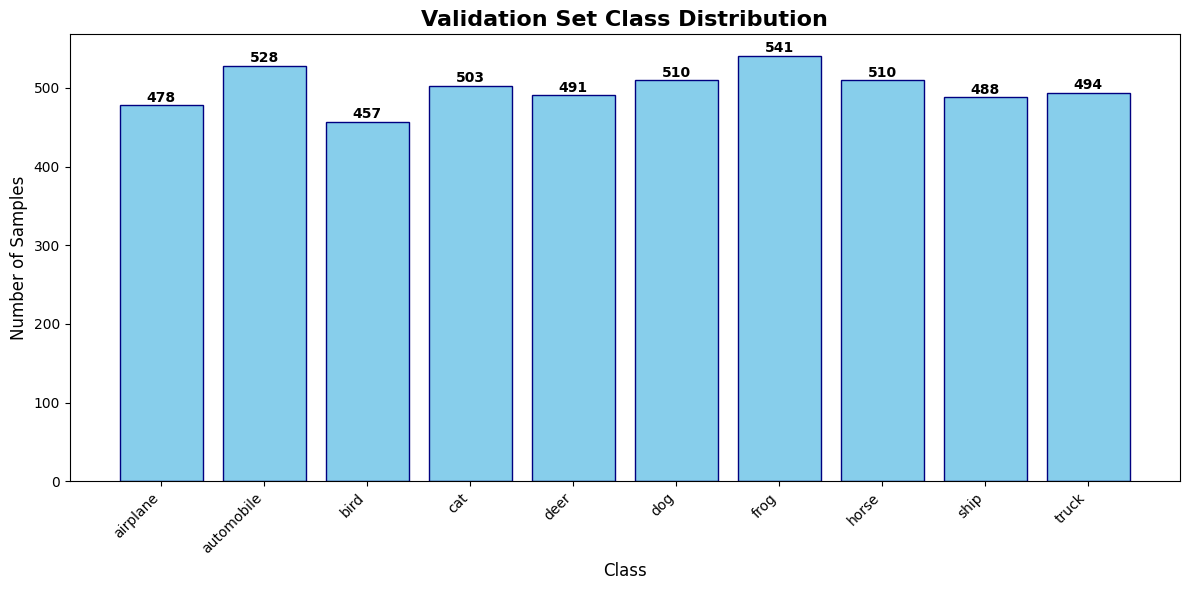

Class distribution in Validation Set Class Distribution:
airplane: 478 samples
automobile: 528 samples
bird: 457 samples
cat: 503 samples
deer: 491 samples
dog: 510 samples
frog: 541 samples
horse: 510 samples
ship: 488 samples
truck: 494 samples
Total samples: 5000
Average samples per class: 500.00


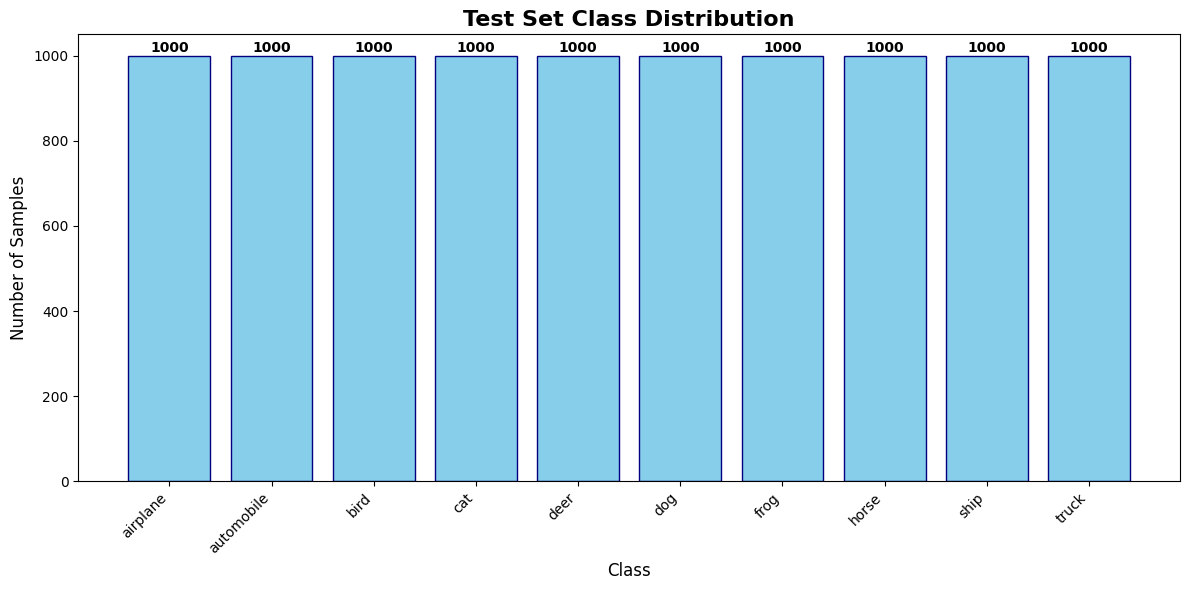

Class distribution in Test Set Class Distribution:
airplane: 1000 samples
automobile: 1000 samples
bird: 1000 samples
cat: 1000 samples
deer: 1000 samples
dog: 1000 samples
frog: 1000 samples
horse: 1000 samples
ship: 1000 samples
truck: 1000 samples
Total samples: 10000
Average samples per class: 1000.00


In [7]:
plot_class_distribution(data_splits['y_train'], "Training Set Class Distribution")
plot_class_distribution(data_splits['y_val'], "Validation Set Class Distribution")  
plot_class_distribution(data_splits['y_test'], "Test Set Class Distribution")

## Sample Images Visualization

This section will showcas a random selection of image samples together with the class name they belong to.

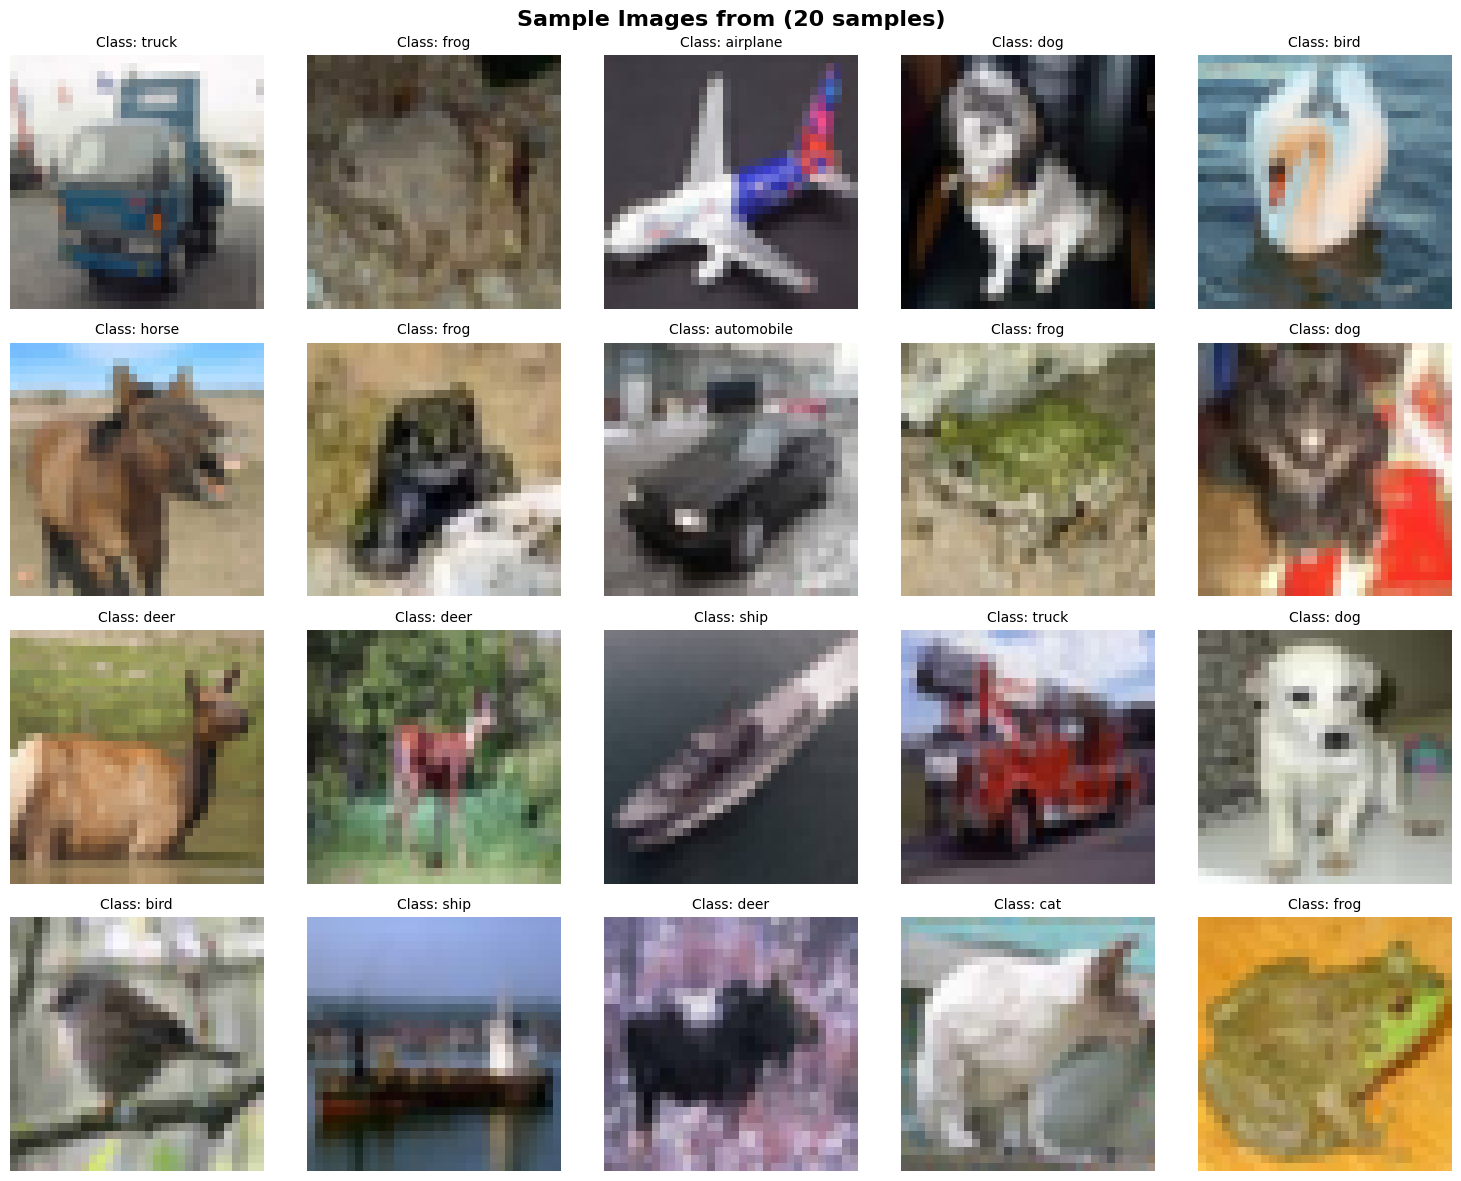

In [8]:
def plt_sample_images(x_data, y_data, num_samples=20, classes=CIFAR10_CLASSES):
    """
    Plots sample images from the dataset.

    Args:
        x_data: Input images.
        y_data: Corresponding labels.
        num_samples: Number of samples.
        classes: List of class names.
    Returns:
        None
    """
    
    indices = np.random.choice(len(x_data), num_samples, replace=False)
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.ravel()

    for i, idx in enumerate(indices):
        axes[i].imshow(x_data[idx])
        axes[i].set_title(f"Class: {classes[y_data[idx]]}", fontsize=10)
        axes[i].axis('off')
    plt.suptitle(f"Sample Images from ({num_samples} samples)", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

plt_sample_images(data_splits['x_train'], data_splits['y_train'], num_samples=20, classes=CIFAR10_CLASSES)

## Create the Training and Validation Data Generators

The generator will feed the model batches of images and label on which basic data augmentation is also applied (interchangeble from CONFIG).

In [9]:
def data_generator(data_splits, config):
    """
    Creates a data generator for the training and the validation sets.

    Args:
        data_splits: Dictionary containing training, validation, and test data.
        config: Configuration parameters.

    Returns:
        tuple: Training and validation data generators.
    """
    
    if config['data_augmentation']:
        # Generator with augmentation
        train_datagen = ImageDataGenerator(
            rotation_range=config['data_aug']['rotation_range'],
            width_shift_range=config['data_aug']['width_shift_range'],
            height_shift_range=config['data_aug']['height_shift_range'],
            horizontal_flip=config['data_aug']['horizontal_flip'],
            zoom_range=config['data_aug']['zoom_range'],
            shear_range=config['data_aug']['shear_range'],
            fill_mode=config['data_aug']['fill_mode'],
        )
        val_datagen = ImageDataGenerator()
        print("Data augmentation enabled!")
    else:
        # Generator without augmentation
        train_datagen = ImageDataGenerator()
        val_datagen = ImageDataGenerator()
        print("Data augmentation disabled!")

    # Converting labels to one-hot vectors
    y_train_one_hot = keras.utils.to_categorical(data_splits['y_train'], config['dataset']['num_classes'])
    y_val_one_hot = keras.utils.to_categorical(data_splits['y_val'], config['dataset']['num_classes'])

    # Creating generators
    train_generator = train_datagen.flow(
        data_splits['x_train'], 
        y_train_one_hot, 
        batch_size=config['batch_size'], 
        shuffle=True
    )
    val_generator = val_datagen.flow(
        data_splits['x_val'], 
        y_val_one_hot, 
        batch_size=config['batch_size'], 
        shuffle=False
    )
    return train_generator, val_generator

train_generator, val_generator = data_generator(data_splits, CONFIG)

Data augmentation enabled!


## Save the Prepared Datasets

In this step the data that has been prepared is saved as a compressed .npz file to help with reproducibility and consistency.

In [13]:
def save_preprocessed_data(data_splits, config):
    """
    Saves the processed data to a .npz file.

    Args:
        data_splits: Dictionary containing training, validation, and test data.
        config: Configuration parameters.

    Returns:
        None
    """

    data_path = os.path.join(config['paths']['data_dir'], 'cifar10_data.npz')
    
    # Check that directory exists
    os.makedirs(config['paths']['data_dir'], exist_ok=True)

    np.savez_compressed(
        data_path,
        x_train=data_splits['x_train'],
        y_train=data_splits['y_train'],
        x_val=data_splits['x_val'],
        y_val=data_splits['y_val'],
        x_test=data_splits['x_test'],
        y_test=data_splits['y_test'],
        config=config
    )
    print(f"Processed data saved to {data_path}")

def load_preprocessed_data(config):
    """
    Loads the processed data from a .npz file.

    Args:
        config: Configuration parameters.

    Returns:
        dict: Dictionary containing training, validation, and test data.
    """

    data_path = os.path.join(config['paths']['data_dir'], 'cifar10_data.npz')
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Processed data file not found: {data_path}")
    
    data = np.load(data_path, allow_pickle=True)
    data_splits = {
        'x_train': data['x_train'],
        'y_train': data['y_train'],
        'x_val': data['x_val'],
        'y_val': data['y_val'],
        'x_test': data['x_test'],
        'y_test': data['y_test']
    }
    print("Processed data loaded successfully.")
    return data_splits

save_preprocessed_data(data_splits, CONFIG)

Processed data saved to ./saved_data\cifar10_data.npz
